In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:15<00:00, 23.1MB/s]
100% 331M/331M [00:16<00:00, 21.7MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip")
zip.extractall("/content")
zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/utkface-new.zip' mode='r'>>

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [7]:
len(age)

23708

In [8]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [9]:
df.shape

(23708, 3)

In [10]:
df.head()

,age,gender,img
0,28,1,28_1_4_20170117202541845.jpg.chip.jpg
1,26,1,26_1_1_20170116174208031.jpg.chip.jpg
2,40,0,40_0_0_20170116232730548.jpg.chip.jpg
3,39,1,39_1_0_20170104185134518.jpg.chip.jpg
4,5,0,5_0_3_20161220223303987.jpg.chip.jpg


In [11]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [12]:
train_df.shape

(20000, 3)

In [13]:
test_df.shape

(3708, 3)

In [14]:
# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='multi_output',
    batch_size=32  # Set batch size here
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='multi_output',
    batch_size=32  # Set batch size here
)


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [16]:
# Custom generator to yield multi-output data
# def multi_output_generator(generator):
#     while True:
#         x, y = generator.__next__()  # Use __next__() instead of next()
#         age_labels = y[:, 0]  # age column
#         gender_labels = y[:, 1]  # gender column
#         yield x, {"age": age_labels, "gender": gender_labels}

# Custom generator function
def multi_output_generator(generator):
    while True:
        x, y = generator.__next__()  # Use __next__() to get next batch
        age_labels = y[0]            # First element in y for 'age' labels
        gender_labels = y[1]         # Second element in y for 'gender' labels
        yield x, {"age": age_labels, "gender": gender_labels}



In [17]:
train_gen_multi_output = multi_output_generator(train_generator)
test_gen_multi_output = multi_output_generator(test_generator)

In [18]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [19]:
resnet = ResNet50(include_top=False,input_shape=(200,200,3))
resnet.trainable = False
output = resnet.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name = 'age')(dense3)
output2 = Dense(1,activation='sigmoid',name = 'gender')(dense4)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
model = Model(inputs =resnet.input,outputs = [output1,output2])

In [21]:
model.compile(optimizer = 'adam',loss = {'age':'mae','gender':'binary_crossentropy'},metrics = {'age':'mae','gender':'accuracy'},loss_weights={'age':1.0,'gender':99.0})

In [22]:
history = model.fit(
    multi_output_generator(train_generator),
    steps_per_epoch=len(train_generator),
    validation_data=multi_output_generator(test_generator),
    validation_steps=len(test_generator),
    epochs=10
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 358ms/step - age_mae: 16.5337 - gender_accuracy: 0.5032 - loss: 165.5081 - val_age_mae: 14.6085 - val_gender_accuracy: 0.5218 - val_loss: 83.1400
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 345ms/step - age_mae: 15.1206 - gender_accuracy: 0.5208 - loss: 83.6739 - val_age_mae: 14.5273 - val_gender_accuracy: 0.5218 - val_loss: 83.0554
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 216s 346ms/step - age_mae: 14.9410 - gender_accuracy: 0.5247 - loss: 83.9161 - val_age_mae: 15.3094 - val_gender_accuracy: 0.5218 - val_loss: 83.8440
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 342ms/step - age_mae: 14.7652 - gender_accuracy: 0.5227 - loss: 83.3201 - val_age_mae: 14.2486 - val_gender_accuracy: 0.5218 - val_loss: 82.7878
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 339ms/step - age_mae: 14.8282 - gender_accuracy: 0.5212 - loss: 83.4244 - val_age_mae: 14.0465 - val_gender_accuracy: 0.5218 - val_loss: 82.5947
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 210s 337m

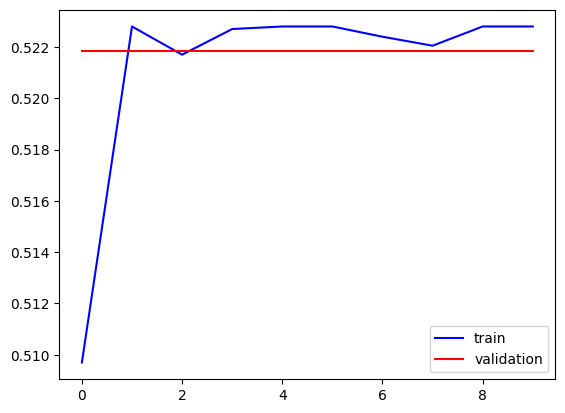

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['gender_accuracy'],color='blue',label='train')
plt.plot(history.history['val_gender_accuracy'],color='red',label='validation')
plt.legend()
plt.show()